# This Kaggle challenge aims to predict the future contagious and fatality cases for COVID-19 in California US, in a way to prepare all medical infrastructure to treat this terrible desease that is hitting so strongly our society.

To do that, Kaggle provided a dataset with the information related to confirmed cases and fatalities in California US since the dates of the outbreak.

First We check the files provided by Kaggle:

In [160]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/covid19-local-us-ca-forecasting-week-1/ca_train.csv
/kaggle/input/covid19-local-us-ca-forecasting-week-1/ca_test.csv
/kaggle/input/covid19-local-us-ca-forecasting-week-1/ca_submission.csv


To check the information we load the files into Pandas dataframes:

In [161]:
# Load data into Pandas dataframes
df_train = pd.read_csv('/kaggle/input/covid19-local-us-ca-forecasting-week-1/ca_train.csv')
df_test = pd.read_csv('/kaggle/input/covid19-local-us-ca-forecasting-week-1/ca_test.csv')
df_submission = pd.read_csv('/kaggle/input/covid19-local-us-ca-forecasting-week-1/ca_submission.csv')

In [162]:
# Check a preview of the data
df_train.tail()

,Id,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities
56,57,California,US,36.1162,-119.6816,2020-03-18,751.0,13.0
57,58,California,US,36.1162,-119.6816,2020-03-19,952.0,18.0
58,59,California,US,36.1162,-119.6816,2020-03-20,1177.0,23.0
59,60,California,US,36.1162,-119.6816,2020-03-21,1364.0,24.0
60,61,California,US,36.1162,-119.6816,2020-03-22,1642.0,30.0


As we can see, the information we need is the date, confirmed cases and fatalities, nevertheless we check that the other columns doesn't change their values:

In [163]:
# Check the properties of the data

print(df_train['Province/State'].unique())
print(df_train['Country/Region'].unique())
print(df_train['Lat'].unique())
print(df_train['Long'].unique())
print(df_train.dtypes)

['California']
['US']
[36.1162]
[-119.6816]
Id                  int64
Province/State     object
Country/Region     object
Lat               float64
Long              float64
Date               object
ConfirmedCases    float64
Fatalities        float64
dtype: object


We describe the data:

In [164]:
df_train.describe()

,Id,Lat,Long,ConfirmedCases,Fatalities
count,61.000000,6.100000e+01,6.100000e+01,61.000000,61.000000
mean,31.000000,3.611620e+01,-1.196816e+02,143.131148,2.475410
std,17.752934,2.149318e-14,1.003015e-13,352.078944,6.355068
min,1.000000,3.611620e+01,-1.196816e+02,0.000000,0.000000
25%,16.000000,3.611620e+01,-1.196816e+02,0.000000,0.000000
50%,31.000000,3.611620e+01,-1.196816e+02,0.000000,0.000000
75%,46.000000,3.611620e+01,-1.196816e+02,0.000000,0.000000
max,61.000000,3.611620e+01,-1.196816e+02,1642.000000,30.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb11940f588>]],
      dtype=object)

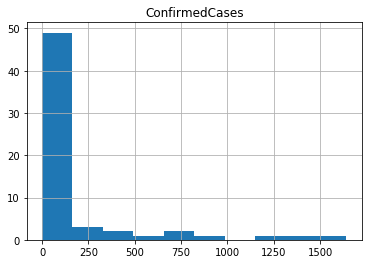

In [165]:
# Check the distribution of the confirmed cases

df_train.hist(column='ConfirmedCases')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb1191660f0>]],
      dtype=object)

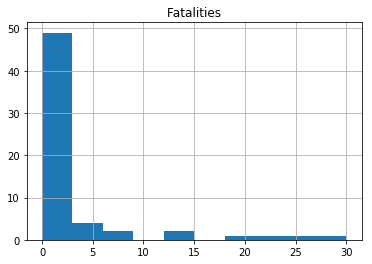

In [166]:
# Check the distribution of the fatalities

df_train.hist(column='Fatalities')

As we can see, most of the registers are from dates when there was no confirmed cases. We update the dataframe to include just the needed columns:

In [167]:
# Take only what we need: date, confirmed cases and fatalities

df_train = df_train[['Date', 'ConfirmedCases', 'Fatalities']]

We transform the date column to the Pandas date format and sort the dataframe:

In [168]:
# Convert Date column to Pandas date and orther to get chronological data

df_train['Date'] = pd.to_datetime(df_train['Date'])
df_train = df_train.sort_values(by=['Date'])

We check the trend of confirmed cases and fatalities in a bar plot:

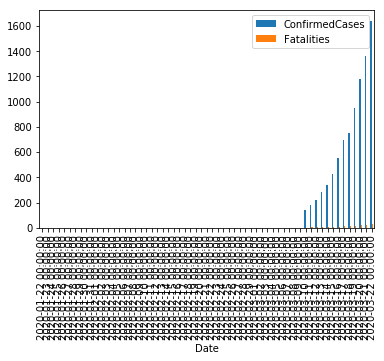

In [169]:
# Check the trend in a chart

df_train.plot.bar(x='Date', y=['ConfirmedCases','Fatalities'])

The growth seems to be exponential, but too many registers contains 0 confirmed cases, just to see closer we plot without this data:

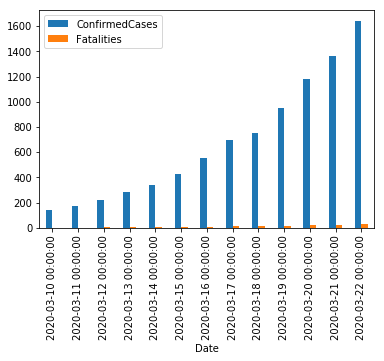

In [170]:
# As the confirmed cases are far away from the start we will focus in that time

df_train2 = df_train.query('ConfirmedCases != 0.0')

df_train2.plot.bar(x='Date', y=['ConfirmedCases', 'Fatalities'])

Now, to make the predictions we first need to expand the features, in this case, we expand the date column:

In [171]:
df_train['Week'] = df_train['Date'].dt.week
df_train['Day'] = df_train['Date'].dt.day
df_train['WeekDay'] = df_train['Date'].dt.dayofweek
df_train['YearDay'] = df_train['Date'].dt.dayofyear

Now we import all models, create them, fit them with data and check the scores for the best result:

In [172]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score

from sklearn.model_selection import train_test_split

predictors = df_train.drop(['Date', 'ConfirmedCases', 'Fatalities'], axis=1)
target = df_train[['ConfirmedCases', 'Fatalities']]
x_train, x_test, y_train, y_test = train_test_split(predictors, target, test_size=0.2, random_state=1)

def scores(alg):
    lin = alg()
    lin.fit(x_train, y_train['ConfirmedCases'])
    y_pred = lin.predict(x_test)
    lin_r = r2_score(y_test['ConfirmedCases'], y_pred)
    s.append(lin_r)
    
    lin.fit(x_train, y_train['Fatalities'])
    y_pred = lin.predict(x_test)
    lin_r = r2_score(y_test['Fatalities'], y_pred)
    s2.append(lin_r)
    
algos = [KNeighborsRegressor, LinearRegression, RandomForestRegressor, GradientBoostingRegressor, Lasso, ElasticNet, DecisionTreeRegressor]

s = []
s2 = []

for algo in algos:
    scores(algo)
    
models = pd.DataFrame({
    'Method': ['KNeighborsRegressor', 'LinearRegression', 'RandomForestRegressor', 'GradientBoostingRegressor', 'Lasso', 'ElasticNet', 'DecisionTreeRegressor'],
    'ScoreCC': s,
    'ScoreF' : s2
})

models.sort_values(by=['ScoreCC', 'ScoreF'], ascending=False)

,Method,ScoreCC,ScoreF
2,RandomForestRegressor,0.990991,0.802541
3,GradientBoostingRegressor,0.969880,0.944679
0,KNeighborsRegressor,0.946436,0.675509
6,DecisionTreeRegressor,0.935700,0.830287
1,LinearRegression,-0.988799,-2.752421
4,Lasso,-0.989566,-2.997877
5,ElasticNet,-0.993343,-2.873853


As we can see, the best prediction score is for the random forest regressor model, and with no hyperparameter tuning, that's amazing. Nevertheless, it can be a good practice to check if the ARIMA model which is highly used nowadays, can perform better.

First we need to check the autocorrelation plot, to fill the ARIMA model parameters:

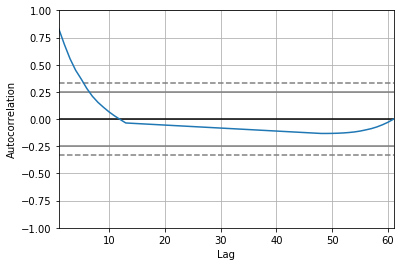

In [173]:
# Now let's try for last an ARIMA model

# First we see that data is not stationary, so we need to check the autocorrelation of the time series

from pandas.plotting import autocorrelation_plot

autocorrelation_plot(df_train['ConfirmedCases'])

The highest autocorrelation significant value is in near the 5th lag, now let's create the model, train it and check coeficients and residuals:

                             ARIMA Model Results                              
Dep. Variable:       D.ConfirmedCases   No. Observations:                   60
Model:                 ARIMA(4, 1, 0)   Log Likelihood                -291.135
Method:                       css-mle   S.D. of innovations             30.171
Date:                Tue, 24 Mar 2020   AIC                            594.270
Time:                        00:12:04   BIC                            606.836
Sample:                             1   HQIC                           599.185
                                                                              
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     92.4593     94.951      0.974      0.330     -93.642     278.560
ar.L1.D.ConfirmedCases     0.4946      0.133      3.719      0.000       0.234       0.755
ar.L

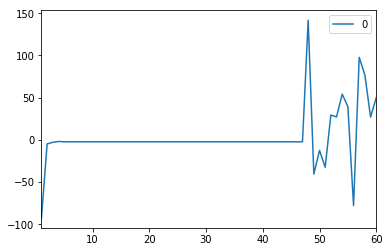

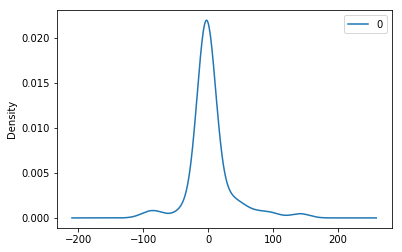

                0
count   60.000000
mean     2.980404
std     32.422715
min    -92.459293
25%     -2.299883
50%     -2.299883
75%     -2.299883
max    141.700117


/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/arima_model.py:1490: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


                             ARIMA Model Results                              
Dep. Variable:           D.Fatalities   No. Observations:                   60
Model:                 ARIMA(4, 1, 0)   Log Likelihood                 -76.293
Method:                       css-mle   S.D. of innovations              0.667
Date:                Tue, 24 Mar 2020   AIC                            164.586
Time:                        00:12:05   BIC                            177.152
Sample:                             1   HQIC                           169.501
                                                                              
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  1.0719        nan        nan        nan         nan         nan
ar.L1.D.Fatalities     0.1494   1.56e-06   9.56e+04      0.000       0.149       0.149
ar.L2.D.Fatalities  

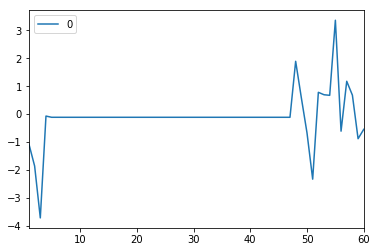

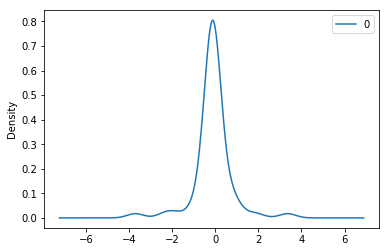

               0
count  60.000000
mean   -0.111639
std     0.863018
min    -3.706724
25%    -0.111832
50%    -0.111832
75%    -0.111832
max     3.354974


In [179]:
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import*

arima_model = ARIMA(df_train['ConfirmedCases'], order=(4,1,0)).fit(disp=0, transparams=True, trend='c')
print(arima_model.summary())

residuals = pd.DataFrame(arima_model.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

arima_model2 = ARIMA(df_train['Fatalities'], order=(4,1,0)).fit(disp=0, transparams=True, trend='c')
print(arima_model2.summary())

residuals2 = pd.DataFrame(arima_model2.resid)
residuals2.plot()
pyplot.show()
residuals2.plot(kind='kde')
pyplot.show()
print(residuals2.describe())

The coefficients are bad for confirmed cases and fatalities, also the residuals show there is a lot of variation that needs to be taken into account. Let's check the predictions in a plot:

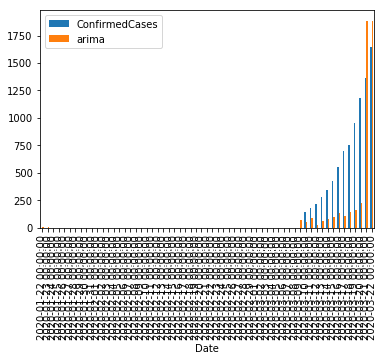

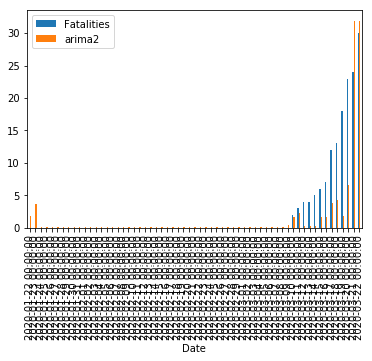

In [180]:
predictions_arima = list(arima_model.predict())
predictions_arima.append(arima_model.forecast()[0][0])
predictions_arima.append(arima_model.forecast()[0][0])

df_train['arima'] = predictions_arima

predictions_arima2 = list(arima_model2.predict())
predictions_arima2.append(arima_model2.forecast()[0][0])
predictions_arima2.append(arima_model2.forecast()[0][0])

df_train['arima2'] = predictions_arima2

df_train.plot.bar(x='Date', y=['ConfirmedCases', 'arima'])
df_train.plot.bar(x='Date', y=['Fatalities', 'arima2'])

In fact, no good results at all, the best model for this case is the random forest regressor.

In [181]:
df_submission.head()

,ForecastId,ConfirmedCases,Fatalities
0,1,1,1
1,2,1,1
2,3,1,1
3,4,1,1
4,5,1,1


In [182]:
print(df_test['Date'].values)
print(len(df_test['Date']))

['2020-03-12' '2020-03-13' '2020-03-14' '2020-03-15' '2020-03-16'
 '2020-03-17' '2020-03-18' '2020-03-19' '2020-03-20' '2020-03-21'
 '2020-03-22' '2020-03-23' '2020-03-24' '2020-03-25' '2020-03-26'
 '2020-03-27' '2020-03-28' '2020-03-29' '2020-03-30' '2020-03-31'
 '2020-04-01' '2020-04-02' '2020-04-03' '2020-04-04' '2020-04-05'
 '2020-04-06' '2020-04-07' '2020-04-08' '2020-04-09' '2020-04-10'
 '2020-04-11' '2020-04-12' '2020-04-13' '2020-04-14' '2020-04-15'
 '2020-04-16' '2020-04-17' '2020-04-18' '2020-04-19' '2020-04-20'
 '2020-04-21' '2020-04-22' '2020-04-23']
43


We need to provide the predictions using the test dataset, so we process the date column just as we did with the training dataset:

In [183]:
df_test = df_test[['ForecastId', 'Date']]

df_test['Date'] = pd.to_datetime(df_test['Date'])
df_test['Week'] = df_test['Date'].dt.week
df_test['Day'] = df_test['Date'].dt.day
df_test['WeekDay'] = df_test['Date'].dt.dayofweek
df_test['YearDay'] = df_test['Date'].dt.dayofyear

df_test.head()

,ForecastId,Date,Week,Day,WeekDay,YearDay
0,1,2020-03-12,11,12,3,72
1,2,2020-03-13,11,13,4,73
2,3,2020-03-14,11,14,5,74
3,4,2020-03-15,11,15,6,75
4,5,2020-03-16,12,16,0,76


We create the random forest regresor, fit it, predict using the test dataset registers and add the results to the dataframe:

In [184]:
model = RandomForestRegressor()
model.fit(x_train, y_train['ConfirmedCases'])

model2 = RandomForestRegressor()
model2.fit(x_train, y_train['Fatalities'])


df_test['ConfirmedCases'] = model.predict(df_test.drop(['Date', 'ForecastId'], axis=1))
df_test['Fatalities'] = model2.predict(df_test.drop(['Date', 'ForecastId', 'ConfirmedCases'], axis=1))

In [185]:
df_final = df_test[['ForecastId', 'ConfirmedCases', 'Fatalities']] 
df_final['ConfirmedCases'] = df_final['ConfirmedCases'].astype(int)
df_final['Fatalities'] = df_final['Fatalities'].astype(int)

df_final.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,ForecastId,ConfirmedCases,Fatalities
0,1,201,3
1,2,254,4
2,3,366,5
3,4,425,6
4,5,608,10


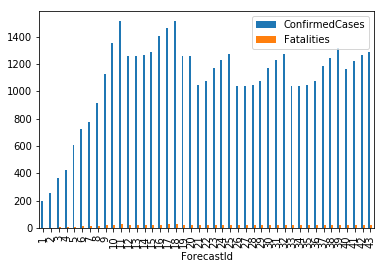

In [186]:
df_final.plot.bar(x='ForecastId', y=['ConfirmedCases', 'Fatalities'])

Those are the predicted values, now let's submit and we are done.

In [ ]:
df_final.to_csv('submission.csv', index=False)